### Note
- Avoid running this notebook on colab, this is for editing purpose only (download a copy and run it on local computer)
- Post in chat if you run into any error
- All model are not properly tunned, thus suffer from overfitting
- The cross-validation code are avaliable in the modelling section. However, it will take you ages to run and my laptop can never finish it. 
- Refer to google doc [(click here)](https://docs.google.com/document/d/1vcpqzyDClhm4hRm3_KediPBeW2tlm-Ewop3mtpd6-m4/edit?usp=sharing) for more detail explanation 

# Task 1

In [ ]:
#packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# load data into df
df = pd.read_csv('train.csv')
df.head()

,rating,reviewText,summary
0,3,Plot Storyline: 5 StarsThis novel accomplished...,3 1/4 Stars
1,3,I did not like how EL ended this one. I don't ...,"It was going great, then just.... ended"
2,5,I love how old fashioned this family is - they...,LOVED ALL 4!
3,5,I loved this story - It's about two friends wh...,friends make the best lovers
4,1,"In the Dark Lands, a virus killed all possibil...",Blatantly sexist and homophobic


In [ ]:
# rating_count = df['rating'].value_counts().sort_index()

# fig, ax = plt.subplots(figsize=(15,10))
# bars = ax.bar(rating_count.index,rating_count.values)

# ax.set_xlabel('rating',size=10)
# ax.set_ylabel('frequency',size=10)
# ax.bar_label(bars,size=20)

# plt.tight_layout()
# plt.show()

## Text Process

In [ ]:
#packages for nlp
import re
import nltk
import string
##download support file 
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('vader_lexicon')
# nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#data cleaning
df['processed_review'] = df['reviewText'].copy().str.lower()
df['processed_summary'] = df['summary'].copy().str.lower()

##remove stop word
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
sw = stopwords.words('english')
df['processed_review'] = df['processed_review'].apply(lambda x: " ".join([x for x in word_tokenize(x) if x not in sw]))
df['processed_summary'] = df['processed_summary'].apply(lambda x: " ".join([x for x in word_tokenize(x) if x not in sw]))

##remove extra spaces
df['processed_review']=df['processed_review'].apply(lambda x: re.sub(' +', ' ', x))
df['processed_summary']=df['processed_summary'].apply(lambda x: re.sub(' +', ' ', x))

##remove all punctuation
df['processed_review'] = df['processed_review'].apply(lambda i: i.translate(str.maketrans('', '', string.punctuation)))
df['processed_summary'] = df['processed_summary'].apply(lambda i: i.translate(str.maketrans('', '', string.punctuation)))

##Lemmatzing
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
df['processed_review']=df['processed_review'].apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in x.split()]))
df['processed_summary']=df['processed_summary'].apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in x.split()]))

In [ ]:
#extract feature
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent = SentimentIntensityAnalyzer()

df['1st_sentence'] = df['reviewText'].apply(lambda i: ' '.join(re.split(r'(?<=[.!?])\s', i)[:1]))
df['last_sentence'] = df['reviewText'].apply(lambda i: ' '.join(re.split(r'(?<=[.!?])\s', i)[-1:]))
df['Polarity_review'] = df['processed_review'].apply(lambda i: sent.polarity_scores(i)['compound'])
df['Polarity_summary'] = df['processed_summary'].apply(lambda i: sent.polarity_scores(i)['compound'])
df['Polarity_1stsent'] = df['1st_sentence'].apply(lambda i: sent.polarity_scores(i)['compound'])
df['Polarity_lastsent'] = df['last_sentence'].apply(lambda i: sent.polarity_scores(i)['compound'])
df['review_length'] = df['processed_review'].apply(lambda i: len(i.split()))
df['upper_count'] = df['reviewText'].apply(lambda i: sum(1 for x in i if x.isupper()))

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## EDA

In [ ]:
#train test split 60 20 20
from sklearn.model_selection import train_test_split

tv_indices, test_indices = train_test_split(np.array(df.index), test_size=0.2, random_state=23)
train_indices, valid_indices = train_test_split(tv_indices, test_size=0.25, random_state=23)

data_train = df.loc[train_indices].copy()
data_valid = df.loc[valid_indices].copy()
data_test = df.loc[test_indices].copy() 

In [ ]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
stopwords.update(['s','read','nt','one'])

_1_star = data_train.loc[df['rating']==1]
_5_star = data_train.loc[df['rating']==5]

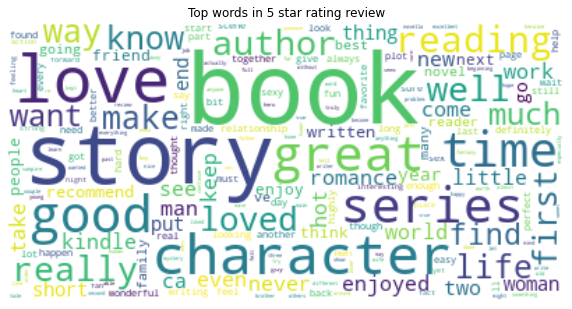

In [ ]:
Top_review = ' '.join(_5_star['processed_review'])

fig, ax = plt.subplots(figsize=(10,8))

wordcloud = WordCloud(stopwords = stopwords,background_color="white",collocations=False,
                      colormap='viridis', max_words=200,random_state=23).generate(Top_review)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Top words in 5 star rating review')
plt.axis('off')
plt.show()

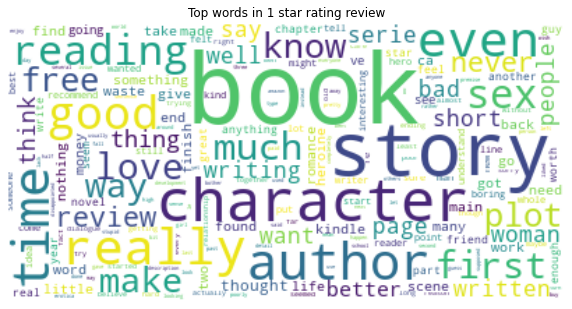

In [ ]:
Low_review = ' '.join(_1_star['processed_review'])

fig, ax = plt.subplots(figsize=(10,8))

wordcloud = WordCloud(stopwords = stopwords,background_color="white",collocations=False,
                      colormap='viridis', max_words=200,random_state=23).generate(Low_review)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Top words in 1 star rating review')
plt.axis('off')
plt.show()

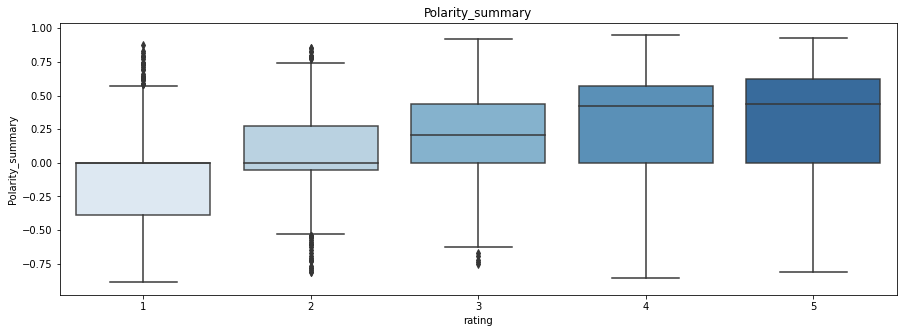

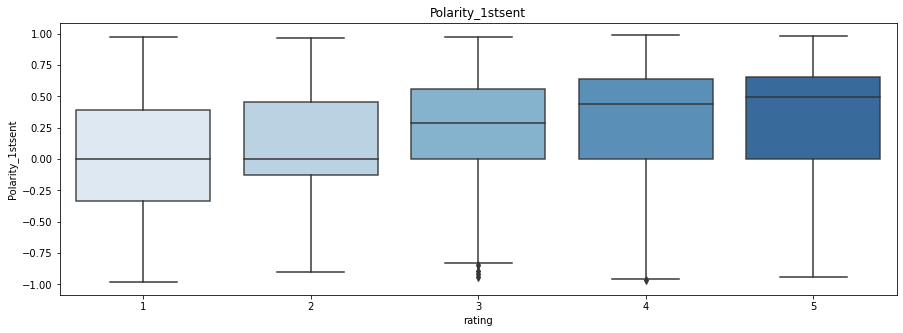

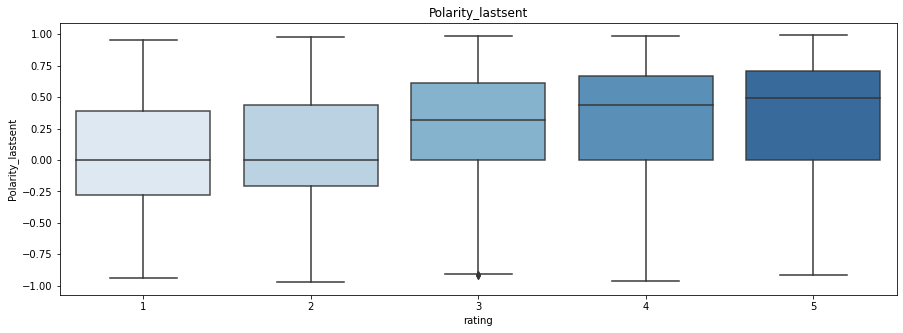

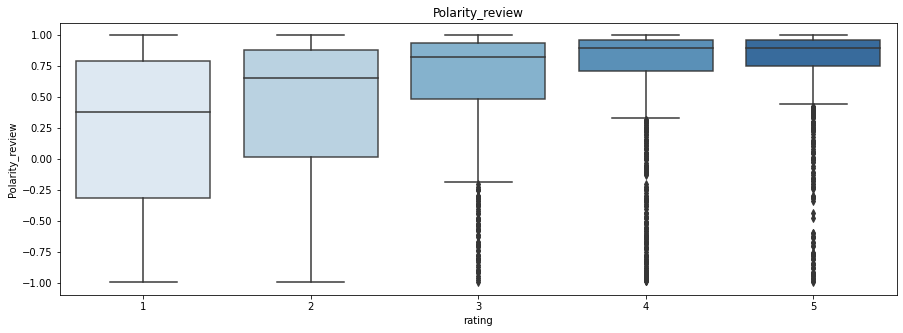

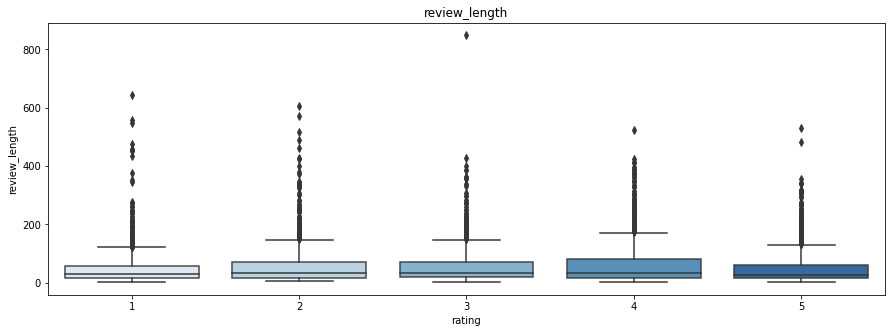

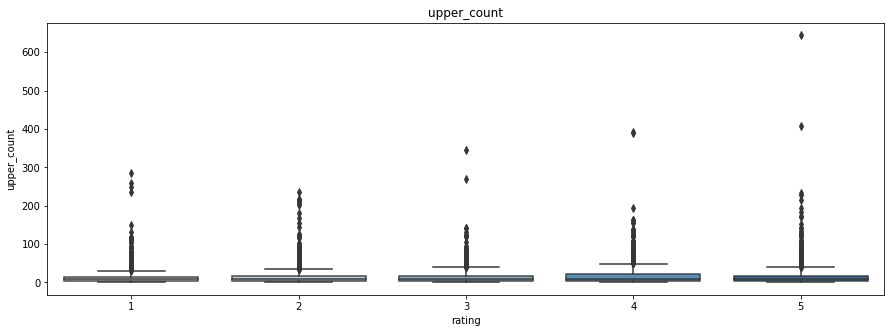

In [ ]:
continuous = ['Polarity_summary','Polarity_1stsent',
              'Polarity_lastsent','Polarity_review',
              'review_length','upper_count']


for i in range(len(continuous)):
    plt.figure(figsize=(15,5))
    sns.boxplot(x = data_train['rating'], y = data_train[continuous[i]],
                boxprops=dict(alpha=.9), palette='Blues')
    plt.title(continuous[i])
    plt.show()

In [ ]:
list_1 = []
list_2 = ['Polarity_review','Polarity_summary','Polarity_1stsent','Polarity_lastsent']

for i in range(1,6):
    mean_var = []
    for z in list_2:
        mean = data_train.loc[data_train['rating']==i][z].mean()
        var = data_train.loc[data_train['rating']==i][z].var() 
        mean_var.append(round(mean,4))
        mean_var.append(round(var,4))
    list_1.append(mean_var)

    
mean_var = pd.DataFrame(list_1,
        columns=['Review Mean','Review Variance','Summary Mean','Summary Variance',
                 '1st Mean','1st Variance','Last Mean','Last Variance',],
        index = range(1,6))
mean_var

,Review Mean,Review Variance,Summary Mean,Summary Variance,1st Mean,1st Variance,Last Mean,Last Variance
1,0.220,0.393,-0.080,0.118,0.020,0.190,0.043,0.183
2,0.404,0.344,0.039,0.100,0.123,0.173,0.102,0.184
3,0.613,0.231,0.191,0.105,0.235,0.173,0.257,0.176
4,0.724,0.190,0.304,0.111,0.323,0.170,0.375,0.148
5,0.762,0.135,0.350,0.113,0.379,0.159,0.411,0.147


## Tfidf

In [ ]:
# using elbow method to decide min_df
from sklearn.feature_extraction.text import TfidfVectorizer
min_df = np.arange(1,51)
tf_size = []
for i in min_df:
    tf_vectorizer = TfidfVectorizer(smooth_idf=False,min_df = i,stop_words = {'english'})
    tf_review = tf_vectorizer.fit_transform(data_train['processed_review'])
    tf_summary = tf_vectorizer.fit_transform(data_train['processed_summary'])
    tf_size.append([i,tf_review.shape[1],tf_summary.shape[1]])

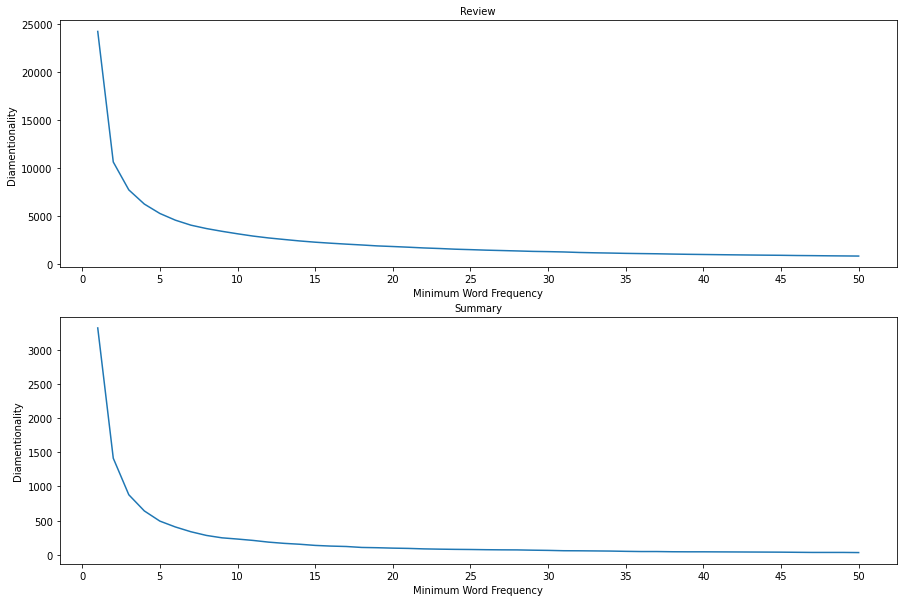

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(np.array(tf_size)[:,0],np.array(tf_size)[:,1])
plt.xticks(np.arange(0,51,5))
plt.title('Review',size=10)
plt.xlabel('Minimum Word Frequency',size=10)
plt.ylabel('Diamentionality',size=10)
plt.subplot(2,1,2)
plt.plot(np.array(tf_size)[:,0],np.array(tf_size)[:,2])
plt.title('Summary',size=10)
plt.xticks(np.arange(0,51,5))
plt.xlabel('Minimum Word Frequency',size=10)
plt.ylabel('Diamentionality',size=10)

plt.show()

In [ ]:
#set tfidf with min_df = 5 Review
tf_review_model = TfidfVectorizer(smooth_idf=False,min_df = 5,stop_words = {'english'})
tf_review_model.fit(data_train['processed_review'])

tf_review_train = tf_review_model.transform(data_train['processed_review'])
tf_review_valid = tf_review_model.transform(data_valid['processed_review'])

tf_summary_model = TfidfVectorizer(smooth_idf=False,min_df = 5,stop_words = {'english'})
tf_summary_model.fit(data_train['processed_summary'])

tf_summary_train = tf_summary_model.transform(data_train['processed_summary'])
tf_summary_valid = tf_summary_model.transform(data_valid['processed_summary'])

In [ ]:
X_train = np.hstack((tf_review_train.toarray(),tf_summary_train.toarray()))
X_valid = np.hstack((tf_review_valid.toarray(),tf_summary_valid.toarray()))

print(X_train.shape,'\n',X_valid.shape)

(5400, 5747) 
 (1800, 5747)


## PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95, random_state=23)
pca.fit(X_train)

PCA(n_components=0.95, random_state=23)

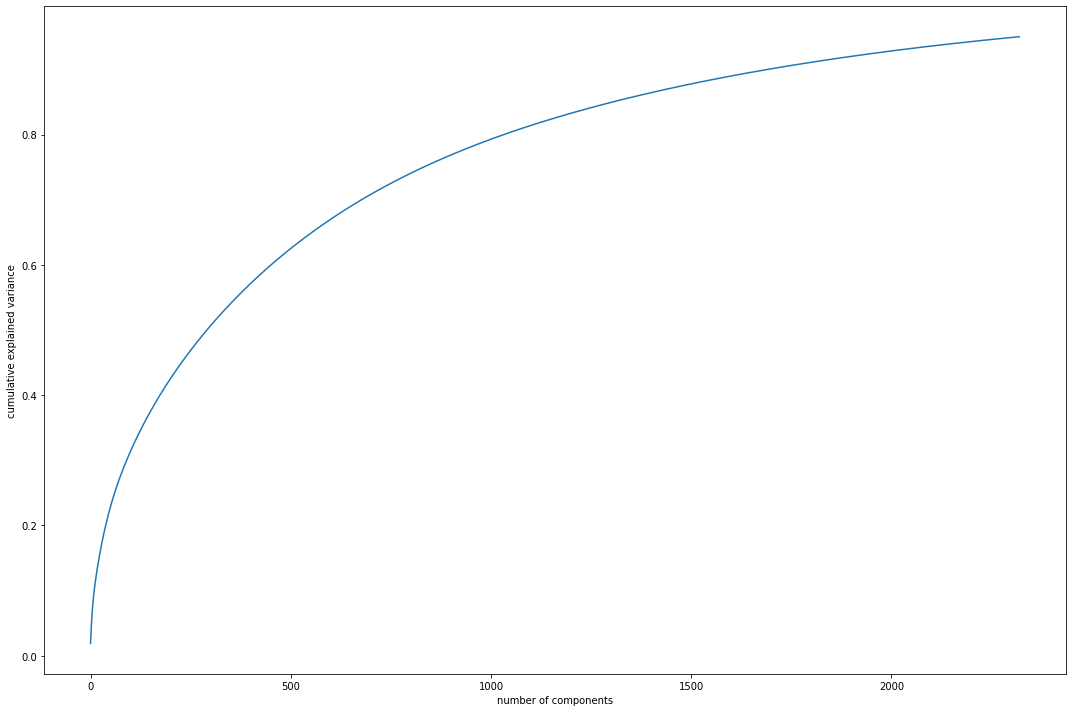

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.tight_layout()
plt.show()

In [ ]:
pca = PCA(n_components=1750, random_state=23)
pca.fit(X_train)
X_train_pca = pd.DataFrame(pca.transform(X_train))
X_valid_pca = pd.DataFrame(pca.transform(X_valid))

In [ ]:
X_train_pca.reset_index(drop=True, inplace=True)
X_valid_pca.reset_index(drop=True, inplace=True)

data_train.reset_index(drop=True, inplace=True)
data_valid.reset_index(drop=True, inplace=True)

In [ ]:
X_train = pd.concat([X_train_pca], axis=1, join = 'outer')
X_valid = pd.concat([X_valid_pca], axis=1, join = 'outer')

Y_train = data_train['rating']
Y_valid = data_valid['rating']

print(X_train.shape,'\n',X_valid.shape)

(5400, 1750) 
 (1800, 1750)


In [ ]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,1740,1741,1742,1743,1744,1745,1746,1747,1748,1749
0,0.081643,0.053257,0.763309,0.383525,0.422850,0.072836,-0.122832,-0.069702,0.070817,-0.029592,...,-0.000196,0.012773,0.007173,0.000550,-0.010135,0.015208,0.032691,0.011434,-0.013641,0.006509
1,-0.044921,-0.035600,-0.150316,0.116034,0.212709,-0.172778,0.218376,0.036861,-0.014176,-0.003941,...,-0.002410,0.004512,-0.005996,-0.009905,0.018228,-0.000810,0.010095,0.004694,-0.017706,-0.021182
2,-0.060756,-0.049292,0.005975,-0.026081,-0.033394,-0.024711,-0.000686,-0.031353,-0.012683,0.010133,...,-0.035799,-0.008664,0.005949,-0.001353,0.024286,-0.013375,0.007112,0.007412,-0.005709,-0.002956
3,-0.067345,-0.040673,0.013691,-0.040693,-0.033746,-0.026273,-0.016138,-0.007521,-0.001470,-0.028383,...,-0.010046,-0.013341,-0.009704,-0.007350,0.021923,0.012279,-0.003508,0.003063,0.014673,-0.000441
4,-0.059179,-0.029511,0.017354,-0.029796,-0.028623,-0.006142,-0.019485,0.016948,-0.019268,-0.026096,...,-0.003126,-0.000584,0.005883,-0.016668,0.006359,-0.006357,0.017797,0.013699,-0.009644,0.018620


# Modeling

## Randomforest with tfidf

### Regression

In [ ]:
%%time

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# rf_model = RandomForestRegressor(random_state = 23)
# tuning_parameters = {'min_samples_leaf': np.arange(10,101,10),'n_estimators': np.arange(50,501,50),
#     'max_depth': np.arange(20,201,20),'max_features': np.arange(20,241,20)}


# rf_search = RandomizedSearchCV(rf_model, tuning_parameters,scoring = 'neg_mean_squared_error',
#                                cv = 5, n_iter = 5, n_jobs = -1,random_state = 23)

# rf_search.fit(X_train.values, Y_train.values)
# rf = rf_search.best_estimator_

# print(rf_search.best_params_, '\n')

CPU times: user 29.8 ms, sys: 4.31 ms, total: 34.2 ms
Wall time: 206 ms


In [ ]:
%%time
#fitting the model without tunned parameters
rfr = RandomForestRegressor(n_estimators = 200, min_samples_leaf = 10, max_features = 220, 
                            max_depth = 120, random_state = 23, n_jobs = -1)
rfr.fit(X_train.values,Y_train.values)

train_pred = rfr.predict(X_train.values)
valid_pred = rfr.predict(X_valid.values)

CPU times: user 2min 51s, sys: 110 ms, total: 2min 52s
Wall time: 44 s


In [ ]:
#threshold
def rf_threshold(np_array):
    for i in range(len(np_array)):
        if np_array[i] <1.8:
            np_array[i] = 1
        elif np_array[i] <2.6:
            np_array[i] = 2 
        elif np_array[i] <3.4:
            np_array[i] = 3
        elif np_array[i] <4.2:
            np_array[i] = 4
        else:
            np_array[i] = 5
    return (np_array)

rf_threshold(train_pred)
rf_threshold(valid_pred)
print(train_pred,'\n',valid_pred)

[4. 5. 3. ... 4. 4. 5.] 
 [3. 3. 4. ... 3. 4. 2.]


In [ ]:
from sklearn.metrics import r2_score, f1_score, mean_squared_error,confusion_matrix, classification_report

print(f'Training RMSE {np.sqrt(mean_squared_error(Y_train,train_pred)):.4f}')
print(f'Training R2 {r2_score(Y_train,(train_pred)):.4f}')
print(f'Training F1 {f1_score(Y_train,(train_pred),average="weighted"):.4f}'+ '\n')
print('Confusion Matrix for training \n',confusion_matrix(Y_train,(train_pred)),'\n')
print('Classification_report for training \n',classification_report(Y_train,(train_pred)),'\n')


print(f'Validation RMSE {np.sqrt(mean_squared_error(Y_valid,(valid_pred))):.4f}')
print(f'Validation R2 {r2_score(Y_valid,(valid_pred)):.4f}')
print(f'Validation F1 {f1_score(Y_valid,(valid_pred),average="weighted"):.4f}'+ '\n')
print('Confusion Matrix for validation \n',confusion_matrix(Y_valid,(valid_pred)))
print('Classification_report for training \n',classification_report(Y_valid,(valid_pred)),'\n')

Training RMSE 0.6715
Training R2 0.7834
Training F1 0.6267

Confusion Matrix for training 
 [[ 345  565   91    0    0]
 [   1  611  315    3    0]
 [   0   65  535  131    0]
 [   0    0  232 1242    3]
 [   0    0   50  547  664]] 

Classification_report for training 
               precision    recall  f1-score   support

           1       1.00      0.34      0.51      1001
           2       0.49      0.66      0.56       930
           3       0.44      0.73      0.55       731
           4       0.65      0.84      0.73      1477
           5       1.00      0.53      0.69      1261

    accuracy                           0.63      5400
   macro avg       0.71      0.62      0.61      5400
weighted avg       0.74      0.63      0.63      5400
 

Validation RMSE 1.1790
Validation R2 0.3656
Validation F1 0.2650

Confusion Matrix for validation 
 [[ 12 187 126  34   0]
 [  4 129 113  31   1]
 [  0  50  87  80   0]
 [  0  36 121 321   9]
 [  0  24  77 327  31]]
Classification_report

### Classification

In [ ]:
# rf_model = RandomForestClassifier(criterion = 'entropy',random_state = 23)
# tuning_parameters = {'min_samples_leaf': np.arange(10,101,10),'n_estimators': np.arange(50,501,50),
#     'max_depth': np.arange(20,201,20),'max_features': np.arange(20,241,20)}

# rf_search = RandomizedSearchCV(rf_model, tuning_parameters,scoring = 'neg_mean_squared_error',
#                                cv = 5, n_iter = 5, n_jobs = -1,random_state = 23)

# rf_search.fit(X_train_pca.values, Y_train.values)
# rf = rf_search.best_estimator_

# print(rf_search.best_params_, '\n')

In [ ]:
%%time
#fitting the model without tunned parameters
rfc = RandomForestClassifier(random_state = 23, max_depth = 180,     
                             n_estimators = 400, max_features = 120, min_samples_leaf = 10,criterion = 'entropy')

rfc.fit(X_train.values,Y_train.values)

train_pred = rfc.predict(X_train.values)
valid_pred = rfc.predict(X_valid.values)

CPU times: user 7min 50s, sys: 239 ms, total: 7min 51s
Wall time: 7min 49s


In [ ]:
print(f'Training RMSE {np.sqrt(mean_squared_error(Y_train,train_pred)):.4f}')
print(f'Training R2 {r2_score(Y_train,(train_pred)):.4f}')
print(f'Training F1 {f1_score(Y_train,(train_pred),average="weighted"):.4f}'+ '\n')
print('Confusion Matrix for training \n',confusion_matrix(Y_train,(train_pred)),'\n')
print('Classification_report for training \n',classification_report(Y_train,(train_pred)),'\n')


print(f'Validation RMSE {np.sqrt(mean_squared_error(Y_valid,(valid_pred))):.4f}')
print(f'Validation R2 {r2_score(Y_valid,(valid_pred)):.4f}')
print(f'Validation F1 {f1_score(Y_valid,(valid_pred),average="weighted"):.4f}'+ '\n')
print('Confusion Matrix for validation \n',confusion_matrix(Y_valid,(valid_pred)))
print('Classification_report for training \n',classification_report(Y_valid,(valid_pred)),'\n')

Training RMSE 0.3970
Training R2 0.9243
Training F1 0.9770

Confusion Matrix for training 
 [[ 971    0    0   23    7]
 [   0  896    0   24   10]
 [  10    0  688   21   12]
 [   4    0    0 1473    0]
 [  12    1    0    0 1248]] 

Classification_report for training 
               precision    recall  f1-score   support

           1       0.97      0.97      0.97      1001
           2       1.00      0.96      0.98       930
           3       1.00      0.94      0.97       731
           4       0.96      1.00      0.98      1477
           5       0.98      0.99      0.98      1261

    accuracy                           0.98      5400
   macro avg       0.98      0.97      0.98      5400
weighted avg       0.98      0.98      0.98      5400
 

Validation RMSE 1.3882
Validation R2 0.1205
Validation F1 0.4179

Confusion Matrix for validation 
 [[221  29   0  94  15]
 [122  53   0  96   7]
 [ 58  22   1 126  10]
 [ 43  22   0 347  75]
 [ 34   6   0 217 202]]
Classification_report

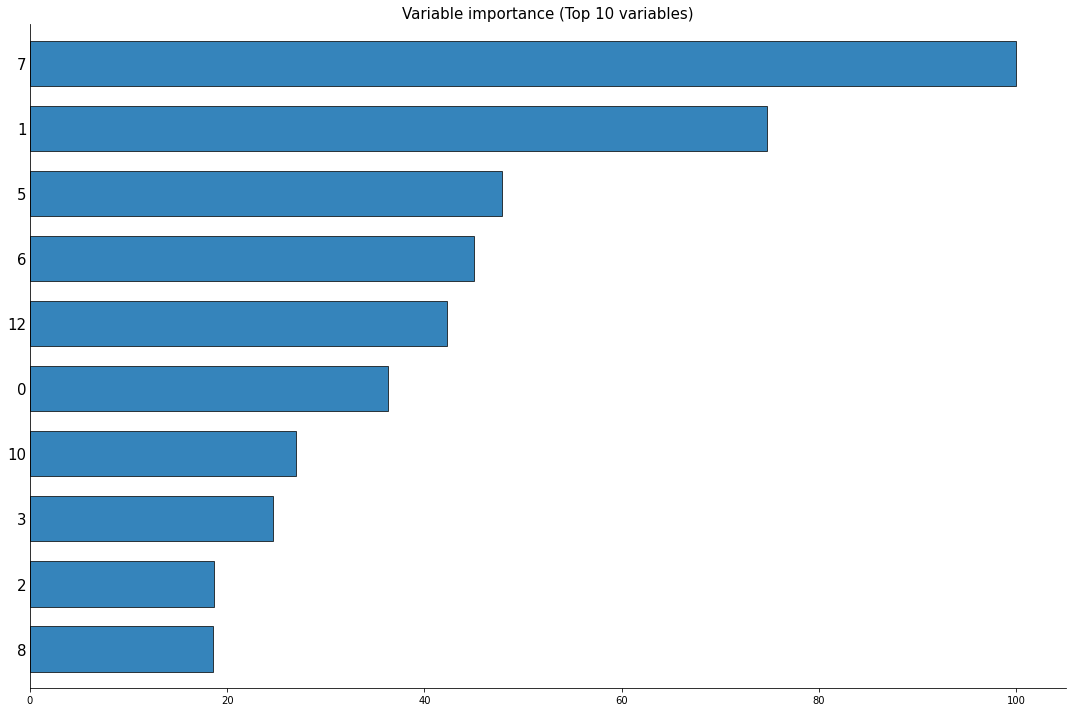

In [ ]:
def plot_feature_importance(model, labels, max_features = 10):
    feature_importance = model.feature_importances_*100
    feature_importance = 100*(feature_importance/np.max(feature_importance))
    table = pd.Series(feature_importance, index = labels).sort_values(ascending=True, inplace=False)
    fig, ax = fig, ax = plt.subplots(figsize=(15,10))
    if len(table) > max_features:
        table.iloc[-max_features:].T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    else:
        table.T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    ax.tick_params(axis=u'y', length=0) 
    ax.set_title('Variable importance (Top 10 variables)', fontsize=15)
    sns.despine()
    return fig, ax

plot_feature_importance(rfc, X_train.columns)
plt.yticks(fontsize=15)
plt.tight_layout()
# plt.savefig('tree_imporatnce.png',dpi = 300)
plt.show()

## Neural Network (Classification)

In [ ]:
import torch
from torch import nn 
import torch.nn.functional as F
from torch import utils

torch.manual_seed(1)
np.random.seed(1)
# !pip install torchtext

In [ ]:
data_train['review_summary'] = data_train['processed_review']+' '+data_train['processed_summary']
data_valid['review_summary'] = data_valid['processed_review']+' '+data_valid['processed_summary']
data_test['review_summary'] = data_test['processed_review']+' '+data_test['processed_summary']

In [ ]:
data_train['rating'] = data_train['rating'] -1 
data_valid['rating'] = data_valid['rating'] -1
data_test['rating'] = data_test['rating'] -1

In [ ]:
class ReviewDataset(utils.data.Dataset):
    def __init__(self, myData):
        super().__init__()
        self.data = myData
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        return (self.data.iloc[idx,0], self.data.iloc[idx,1])

In [ ]:
train_torch = ReviewDataset(data_train[["rating",'review_summary']])
valid_torch = ReviewDataset(data_valid[["rating",'review_summary']])
test_torch = ReviewDataset(data_test[["rating",'review_summary']])

In [ ]:
# Tokenization 
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab
from collections import Counter

tokenizer = get_tokenizer('basic_english')

In [ ]:
counter = Counter() 
for msg in data_train['review_summary']:
    counter.update(tokenizer(msg))
vocabulary = vocab(counter, min_freq = 5)

vocabulary.set_default_index(0)

In [ ]:
def collate_batch(batch):
    
    target_list, text_list, offsets = [], [], [] 
    
    for idx in range(len(batch)):
        
        _label = batch[idx][0]
        _text = batch[idx][1]
        
        target_list.append( _label )
        tokens = doc_tokenizer( _text )
        text_list.append(tokens)
        
        if idx == 0:
            offsets.append(0)
        else:
            offsets.append(offsets[-1] + tokens.size(0))
    
    target_list = torch.tensor(target_list, dtype=torch.int64)
    offsets = torch.tensor(offsets)
    text_list = torch.cat(text_list)
    
    return target_list, text_list, offsets

def doc_tokenizer(doc):
    return torch.tensor([vocabulary[token] for token in tokenizer(doc)], dtype=torch.long)

In [ ]:
torch.manual_seed(0)

batchSize = 512

train_loader = utils.data.DataLoader(train_torch, batch_size=batchSize, shuffle=True, collate_fn=collate_batch)
valid_loader = utils.data.DataLoader(valid_torch, batch_size=batchSize, shuffle=True, collate_fn=collate_batch)
test_loader = utils.data.DataLoader(test_torch, batch_size=batchSize, shuffle=False, collate_fn=collate_batch)

In [ ]:
class MulticlassClassifier(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, 32, mode='mean') # embedding layer
        self.Linear1 = nn.Linear(32, 16)
        self.Linear2 = nn.Linear(16, 1)
        self.Dropout = nn.Dropout(p=0.2)
    
    def forward(self, text, offsets):
        # note we need offsets to indicate which document we have
        out = self.embedding(text, offsets)
        out = self.Dropout(out)
        out = self.Linear1(out)
        out = self.Linear2(out)
        return out

    
embed_dim = 32
model = MulticlassClassifier(len(vocabulary), embed_dim)

In [ ]:
for name, param in model.named_parameters():
    print(name, param.shape)

embedding.weight torch.Size([6039, 32])
Linear1.weight torch.Size([16, 32])
Linear1.bias torch.Size([16])
Linear2.weight torch.Size([1, 16])
Linear2.bias torch.Size([1])


In [ ]:
def evaluate(dataloader):
    
    y_pred = torch.tensor([]) # store prediction
    y_true = torch.tensor([]) # store true label
    
    model.eval()
    with torch.no_grad():
        for label, text, offsets in dataloader:
            y_pred_batch = model(text, offsets)
            
            y_pred = torch.cat((y_pred, y_pred_batch.squeeze()))
            y_true = torch.cat((y_true, label.squeeze()))
            
    return y_pred, y_true

In [ ]:
loss_total = torch.zeros((50,1))

def training_function(epochs = 50,lr=0.001):
    
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001) 
    for epoch in range(epochs):
        
        for y_train, text, offsets in train_loader:
            # zero the parameter gradients
            optimizer.zero_grad()

            # calulate output and loss 
            y_pred_train = model(text, offsets)
            loss = loss_fn(y_pred_train.squeeze(), y_train.float())
            # backprop and take a step
            loss.backward()
            optimizer.step()
            
        #evaluate on validation set
        if epoch % 1 == 0: 
            y_pred_val, y_valid = evaluate(valid_loader)
            loss_val = loss_fn(y_pred_val, y_valid.long())

            label_pred_val = torch.round(y_pred_val)
            acc = (label_pred_val == y_valid).float().sum()/y_valid.shape[0]  

            model.train() 
            loss_total[i] = loss
            print('Epoch {}: {:.4f} (train), {:.4f} (val), {:.4f} (val acc)'.format(epoch, loss, loss_val, acc))
            

In [ ]:
torch.manual_seed(1)
np.random.seed(1)



for i in range(3):
    
    lr_decay=0.1
    initial_lr = 0.01
    print(f'{"":<20}Round {i+1} training; LR: {initial_lr*lr_decay**i}')
    training_function(epochs=20, lr=initial_lr*lr_decay**i)

                    Round 1 training; LR: 0.01
Epoch 0: 2.9334 (train), 2.6326 (val), 0.1456 (val acc)
Epoch 1: 2.7195 (train), 2.4600 (val), 0.1694 (val acc)
Epoch 2: 2.2025 (train), 2.2808 (val), 0.1472 (val acc)
Epoch 3: 2.3196 (train), 2.1928 (val), 0.1928 (val acc)
Epoch 4: 1.9560 (train), 2.2335 (val), 0.1544 (val acc)
Epoch 5: 2.0751 (train), 2.1691 (val), 0.1694 (val acc)
Epoch 6: 2.1586 (train), 2.1457 (val), 0.1578 (val acc)
Epoch 7: 2.2715 (train), 1.9790 (val), 0.1861 (val acc)
Epoch 8: 2.0519 (train), 2.1415 (val), 0.1583 (val acc)
Epoch 9: 2.3063 (train), 1.9171 (val), 0.1833 (val acc)
Epoch 10: 1.6994 (train), 2.0355 (val), 0.1806 (val acc)
Epoch 11: 1.6189 (train), 2.0935 (val), 0.1606 (val acc)
Epoch 12: 1.9762 (train), 1.9176 (val), 0.2044 (val acc)
Epoch 13: 1.7665 (train), 1.8831 (val), 0.2044 (val acc)
Epoch 14: 2.0782 (train), 1.9766 (val), 0.1933 (val acc)
Epoch 15: 1.8584 (train), 1.8271 (val), 0.1850 (val acc)
Epoch 16: 1.9616 (train), 1.9274 (val), 0.1967 (val

In [ ]:
# prediction on valid data
y_pred_valid, y_true_valid = evaluate(valid_loader)

label_pred_val = torch.round(y_pred_valid)

print(f'Validation F1 {f1_score(y_true_valid,label_pred_val,average="weighted"):.4f}'+ '\n')
print(confusion_matrix(y_true_valid, label_pred_val))
print(classification_report(y_true_valid, label_pred_val))

Validation F1 0.1679

[[  0   0   0   0   0   0]
 [  0  11  57 277  14   0]
 [  0   1  47 209  20   1]
 [  0   0  18 165  33   1]
 [  1   0   6 335 143   2]
 [  0   1   3 255 194   6]]
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.85      0.03      0.06       359
         1.0       0.36      0.17      0.23       278
         2.0       0.13      0.76      0.23       217
         3.0       0.35      0.29      0.32       487
         4.0       0.60      0.01      0.03       459

    accuracy                           0.21      1800
   macro avg       0.38      0.21      0.14      1800
weighted avg       0.49      0.21      0.17      1800



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# prediction on train data
y_pred_train, y_true_train = evaluate(train_loader)

label_pred_train = torch.round(y_pred_train)

print(f'Training F1 {f1_score(y_true_train,label_pred_train,average="weighted"):.4f}'+ '\n')
print(confusion_matrix(y_true_train, label_pred_train))
print(classification_report(y_true_train, label_pred_train))

Training F1 0.1717

[[  8 184 707  95   7]
 [  3 115 718  90   4]
 [  0  43 567 119   2]
 [  1  33 963 467  13]
 [  0  18 695 516  32]]
              precision    recall  f1-score   support

         0.0       0.67      0.01      0.02      1001
         1.0       0.29      0.12      0.17       930
         2.0       0.16      0.78      0.26       731
         3.0       0.36      0.32      0.34      1477
         4.0       0.55      0.03      0.05      1261

    accuracy                           0.22      5400
   macro avg       0.41      0.25      0.17      5400
weighted avg       0.42      0.22      0.17      5400

